In [11]:
import numpy as np
rng = np.random.default_rng()

def heatbath_update(U,beta):
    site = tuple(rng.integers(0,len(U),4))
    theta = sample_angle(beta)
    U[site] = np.exp(1j*theta)

def sample_angle(beta):
    alpha = np.sqrt(2*beta)*beta

    while True:
        Z = rng.uniform(0,1)
        x = -1 + np.log(1 + np.exp(2*alpha - 1)*Z)

        Q = np.exp(alpha*(np.cos(np.pi/2*(1-x))-x))
        Q_max = np.exp(0.2105137*alpha)

        Z_prime = rng.uniform(0,1)
        if Q/Q_max > Z_prime:
            angle = np.pi*(1-x)/2
            return angle

def wilson_loop(U, loop_sites):
    site1, site2, site3, site4 = loop_sites
    product = np.dot(U[site1], U[site2]) * np.dot(U[site2], U[site3]) * np.dot(U[site3], U[site4]) * np.dot(U[site4], U[site1])
    return np.real(np.trace(product))


def run_heatbath(U, beta, n, loop_sites_list):
    wilson_loop_sum = 0.0
    total_plaquettes = len(loop_sites_list)

    for _ in range(n):
        heatbath_update(U, beta)

        # Sum Wilson loops for all plaquettes
        loop_value_sum = 0.0
        for loop_sites in loop_sites_list:
            loop_value_sum += wilson_loop(U, loop_sites)

        # Add the sum of loop values for this update
        wilson_loop_sum += loop_value_sum

    # Average Wilson loop value over all updates and all plaquettes
    return wilson_loop_sum / (n * total_plaquettes)

def create_plaquette(x, y, z, t):
    # Assuming a 4-dimensional lattice, create a plaquette that takes a "loop" from
    # one point (x, y, z, t) to its neighbors in the lattice.
    return [
        (x, y, z, t),           # Original site
        (x+1, y, z, t),         # Neighbor in x direction
        (x+1, y+1, z, t),       # Neighbor in x and y direction
        (x, y+1, z, t),         # Neighbor in y direction
    ]

def create_plaquettes(width):
    loop_sites_list = []
    for x in range(width-1):   # Loop over the entire grid (excluding edges for plaquettes)
        for y in range(width-1):
            for z in range(width-1):
                for t in range(width-1):
                    loop_sites_list.append(create_plaquette(x, y, z, t))
    return loop_sites_list

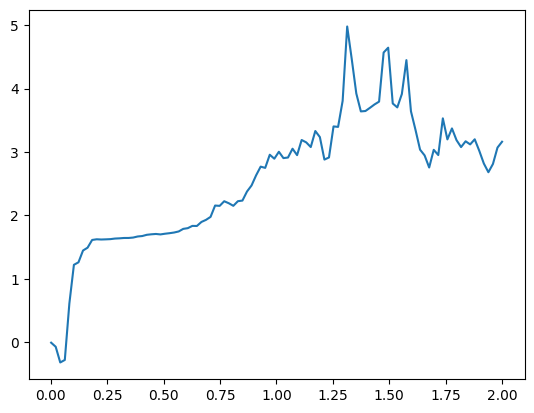

In [1]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng()

def heatbath_update(U, beta):
    site = tuple(rng.integers(0, len(U), 4))
    theta = sample_angle(beta)
    U[site] = np.exp(1j * theta * np.array([[0, -1j], [1j, 0]]))  # Sample SU(2) matrix

def sample_angle(beta):
    alpha = np.sqrt(2 * beta) * beta
    while True:
        Z = rng.uniform(0, 1)
        x = -1 + np.log(1 + np.exp(2 * alpha - 1) * Z)
        Q = np.exp(alpha * (np.cos(np.pi / 2 * (1 - x)) - x))
        Q_max = np.exp(0.2105137 * alpha)
        Z_prime = rng.uniform(0, 1)
        if Q / Q_max > Z_prime:
            angle = np.pi * (1 - x) / 2
            return angle

def wilson_loop(U, loop_sites):
    site1, site2, site3, site4 = loop_sites
    product = np.dot(U[site1], U[site2]) @ np.dot(U[site2], U[site3]) @ np.dot(U[site3], U[site4]) @ np.dot(U[site4], U[site1])
    return np.real(np.trace(product))

def plaquette_action(U, loop_sites):
    site1, site2, site3, site4 = loop_sites
    product = np.dot(U[site1], U[site2]) @ np.dot(U[site2], U[site3]) @ np.dot(U[site3], U[site4]) @ np.dot(U[site4], U[site1])
    # Compute the action of the plaquette
    return 0.5 * np.real(np.trace(product))

def average_energy(U, loop_sites_list):
    energy_sum = 0.0
    total_plaquettes = len(loop_sites_list)
    for loop_sites in loop_sites_list:
        energy_sum += plaquette_action(U, loop_sites)
    # Average energy per plaquette
    return energy_sum / total_plaquettes

def run_heatbath_with_energy(U, beta, n, loop_sites_list):
    wilson_loop_sum = 0.0
    energy_sum = 0.0
    total_plaquettes = len(loop_sites_list)
    for _ in range(n):
        heatbath_update(U, beta)
        loop_value_sum = 0.0
        for loop_sites in loop_sites_list:
            loop_value_sum += wilson_loop(U, loop_sites)
        wilson_loop_sum += loop_value_sum
        energy_sum += average_energy(U, loop_sites_list)
    return wilson_loop_sum / (n * total_plaquettes), energy_sum / (n * total_plaquettes)

def create_plaquette(x, y, z, t):
    return [
        (x, y, z, t),
        (x+1, y, z, t),
        (x+1, y+1, z, t),
        (x, y+1, z, t),
    ]

def create_plaquettes(width):
    loop_sites_list = []
    for x in range(width-1):
        for y in range(width-1):
            for z in range(width-1):
                for t in range(width-1):
                    loop_sites_list.append(create_plaquette(x, y, z, t))
    return loop_sites_list

# Lattice size
width = 4
U = np.exp(2j * np.pi * rng.random((width, width, width, width, 2, 2)))  # Initialize as 2x2 matrices
n_updates = 1000
beta_values = np.linspace(0.001, 2, 100)

# Create plaquettes for the entire grid
loop_sites_list = create_plaquettes(width)

wilson_loops = []
energies = []
for beta_value in beta_values:
    avg_wilson_loop, avg_energy = run_heatbath_with_energy(U, beta_value, n_updates, loop_sites_list)
    wilson_loops.append(avg_wilson_loop)
    energies.append(avg_energy)

plt.plot(beta_values, energies)